In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
import chromadb
import json
import pandas as pd
import matplotlib.pyplot as plt
from chromadb.utils.data_loaders import ImageLoader
from weavingtools.embedding_tools import SigLIPEmbedder
from weavingtools.weaving_tools import plot_query_results
import scipy.spatial as sp
import seaborn as sns
import numpy as np
sns.set()

In [2]:
checkpoint = 'google/siglip-base-patch16-224'

siglip_embedder = SigLIPEmbedder(checkpoint)

client = chromadb.PersistentClient(path="ce_comms_db")

data_loader = ImageLoader()

collection_db = client.get_or_create_collection(name="ce_comms_db", 
                                             metadata={"hnsw:space": "cosine"},
                                             embedding_function=siglip_embedder, 
                                             data_loader=data_loader
                                            )

# Check database

In [3]:
collection_df = pd.read_csv('data/communications_data.csv')

In [4]:
collection_df.shape[0], collection_db.count()

(5414, 26928)

# Compare a pair of items across modalities

In [5]:
data = collection_db.get()# where={'collection':'smg'}

In [6]:
#idx1, idx2 = 100, 8003

In [7]:
rids = [record['record_id'] for record in data['metadatas']]
ids = data['ids']
r1 = collection_db.get(where={'record_id':'co209568'},include=['embeddings','metadatas'])
r2 = collection_db.get(where={'record_id':'T.1919.17'},include=['embeddings','metadatas'])
im_1 = [r['input_modality'] for r in r1['metadatas']]
im_2 = [r['input_modality'] for r in r2['metadatas']]
r1_emb = np.matrix(r1['embeddings'])
r2_emb = np.matrix(r2['embeddings'])
mult = 1 - sp.distance.cdist(r1_emb,r2_emb, 'cosine')

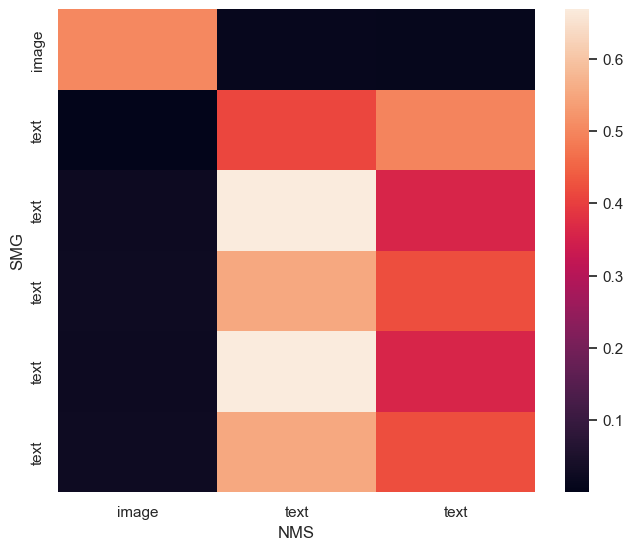

In [8]:
sns.set(rc={'figure.figsize':(7.7,6.27)})
ax = sns.heatmap(mult, yticklabels=im_1, xticklabels=im_2)
ax.set(xlabel='NMS', ylabel='SMG')
plt.show()

# Collection Level Comparison

In [25]:
from weavingtools.weaving_tools import compute_similarities
from weavingtools.annotation_tools import *
from weavingtools.weaving_tools import *
from tqdm.notebook import tqdm
import networkx as nx

In [26]:
annotator = 'KB'
coll1, coll2 = 'smg','nms'
modality1, modality2 = 'text', 'text'

In [27]:
inputs = get_data(collection_db,coll1,coll2, modality1, modality2)

In [ ]:
import pandas as pd

# Create a sample DataFrame
df = pd.DataFrame({'A': [1, 2, 3], 'A.1': [4, 5, 6], 'B': [7, 8, 9], 'B.1': [10, 11, 12], 'C': [13, 14, 15]})

# Split the DataFrame based on column names
groups = df.groupby(df.columns, axis=1)

# Iterate over the groups and print each group
for name, group in groups:
    print(f"Group Name: {name}")
    print(group)
    print()


In [29]:
similarities = compute_similarities(inputs)

['co8404521',
 'co8404521',
 'co8404521',
 'co8404521',
 'co8404521',
 'co8404521',
 'co8404521',
 'co8404521',
 'co8404521',
 'co8404521']

In [145]:

row_groups = [i for i in inputs['coll1_rids'] for _ in range(len(inputs['coll2_rids'])) ]
col_groups =  inputs['coll2_rids'] * len(inputs['coll1_rids'] )

df = pd.DataFrame({'row_group':row_groups,
                   'column_group': col_groups,
                   'value': similarities.flatten()}) # 

# Calculate the mean for each combination of groups
mean_df = df.groupby(['row_group', 'column_group']).mean()

print(mean_df)

#df = pd.DataFrame(similarities,index=inputs['coll1_rids'],columns=inputs['coll2_rids'])
#groups = df.groupby(df.index, axis=0).apply(lambda x: x.groupby(df.columns,axis=1))

                           value
row_group column_group          
co15030   D.2015.17     0.509253
          D.2015.18     0.511996
          D.2015.19     0.497470
          D.2015.20     0.542783
          D.2015.26     0.438962
...                          ...
co8871904 T.2019.143    0.426256
          T.2019.93     0.517210
          T.2021.32.1   0.535341
          T.2021.32.2   0.500356
          YT.2017.202   0.461046

[2363526 rows x 1 columns]


<Axes: xlabel='None-column_group', ylabel='row_group'>

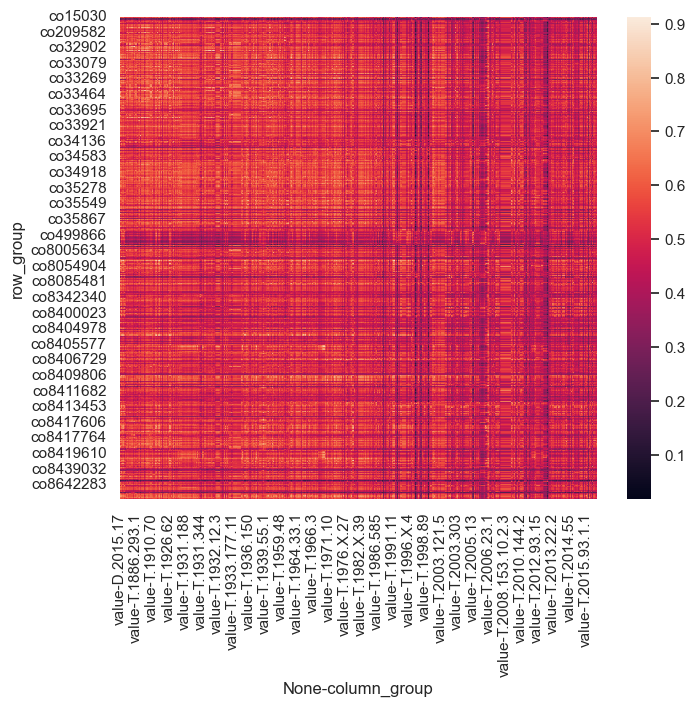

In [148]:
sns.heatmap(mean_df.unstack())

In [137]:
similarities.flatten().shape

(28084728,)

In [136]:
groups.iloc[0].apply(np.shape)

D.2015.17      (2, 2)
D.2015.18      (2, 4)
D.2015.19      (2, 2)
D.2015.20      (2, 2)
D.2015.26      (2, 2)
                ...  
T.2019.143     (2, 2)
T.2019.93      (2, 8)
T.2021.32.1    (2, 2)
T.2021.32.2    (2, 2)
YT.2017.202    (2, 1)
Length: 506, dtype: object

In [129]:
groups.apply(lambda x: np.array(x))

co15030      [[0.49324111759894007, 0.5010752298103774, 0.5...
co15032      [[0.489770886384048, 0.5437423010129794, 0.545...
co15035      [[0.29494838495104503, 0.33047805558457355, 0....
co15041      [[0.4705430271708726, 0.4625417398039957, 0.46...
co15043      [[0.5861701558635906, 0.5628628064004413, 0.56...
                                   ...                        
co8871029    [[0.4326818664094132, 0.4533937169775437, 0.45...
co8871031    [[0.5632070953444208, 0.5394634458812491, 0.57...
co8871587    [[0.3963156560920611, 0.4074245330211723, 0.47...
co8871589    [[0.6458702683034956, 0.5599497490460299, 0.58...
co8871904    [[0.5718236130596176, 0.5393431622422683, 0.58...
Length: 4671, dtype: object

In [98]:
print(groups.iloc[0].apply(lambda x: np.array(x).flatten()).mean())

[]


In [57]:
inputs['coll1_rids'][100], inputs['coll2_rids'][803]

('co8084879', 'T.2006.23.1')

In [68]:
type(similarities)

numpy.ndarray

In [72]:


similarities[x[:,np.newaxis],y]

[1000 1001] [803 804]


array([[0.46533601, 0.34103283],
       [0.46533601, 0.34103283]])

In [37]:
len(inputs['coll1_rids']),similarities.shape

(20118, (20118, 1396))

In [13]:
edges, image_similarities, inputs = get_edges(collection_db,coll1,coll2, modality1, modality2, percentile); len(edges)

17275

<Axes: >

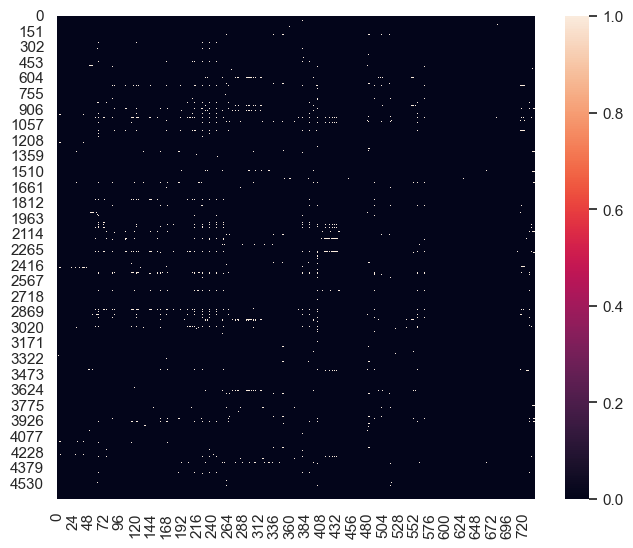

In [15]:
sns.heatmap(image_similarities)

In [12]:


def retrieve_records(coll,modality):   
    filters = {
        "$and": [
            {
                "input_modality": {
                    "$eq": modality
                }
            },
            {
                "collection": {
                    "$eq" : coll
                }
            }
            ]
        }

    return collection_db.get(
                where=filters,
                include=['embeddings','metadatas'] 
                    )


def get_data(coll1, coll2, modality1, modality2): 
    data1 = retrieve_records(coll1, modality1)
    data2 = retrieve_records(coll2, modality2)
    
    inputs = dict()
    
    for i,(name,data) in enumerate([(coll1, data1), (coll2,data2)]):
        i+=1
        inputs[f'coll{i}_ids'] = data['ids']
        inputs[f'coll{i}_rids'] = [record['record_id'] for record in data['metadatas']]
        inputs[f'coll{i}_emb'] = np.matrix(data['embeddings'])
        inputs[f'coll{i}_len'] = len(data['ids'])
        inputs[f'coll{i}_name'] = name
    
    return inputs

def create_graph(coll1, coll2, modality1, modality2, percentile=99.5):
    inputs = get_data(coll1, coll2, modality1, modality2)
    image_similarities = 1 - sp.distance.cdist(inputs['coll1_emb'],inputs['coll2_emb'], 'cosine')
    
    threshold = np.percentile(image_similarities.reshape(-1), percentile) 
    image_similarities_binary = image_similarities.copy()
    image_similarities_binary[image_similarities_binary >= threshold] = 1
    image_similarities_binary[image_similarities_binary < threshold] = 0
    edges = [(inputs['coll1_rids'][i],
              inputs['coll2_rids'][j]) 
                           for i,j in zip(*np.where(image_similarities_binary > 0))]
    
    coll1_node_ids = list(np.where(image_similarities_binary.sum(axis=1) > 0)[0])
    coll2_node_ids = list(np.where(image_similarities_binary.sum(axis=0) > 0)[0])
    
    # is there a more elegant way for doing this?
    coll1_mapping = {i:j for i,j in zip(range(inputs['coll1_len']),inputs['coll1_rids'])}
    coll2_mapping = {i:j for i,j in zip(range(inputs['coll2_len']),inputs['coll2_rids'])}
    
    G = nx.Graph()
    
    G.add_edges_from([(i,j) for i,j in tqdm(edges)])

    G.add_nodes_from([(coll1_mapping[nid],  
                {#'url' : collection_df[collection_df.record_id==coll1_mapping[nid]].img_url.values[0], 
                 'color':'blue', 'collection': inputs['coll1_name'],
                })
                 for nid in tqdm(coll1_node_ids)])

    G.add_nodes_from([(coll2_mapping[nid], 
                 {#'url' : collection_df[collection_df.record_id==coll2_mapping[nid]].img_url.values[0],
                  'color':'red', 'collection': inputs['coll2_name'],
                 })
               for nid in tqdm(coll2_node_ids)])

    return G, image_similarities_binary

G, img_sim_bin = create_graph('smg','nms','image','image')

  0%|          | 0/31440 [00:00<?, ?it/s]

  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

In [13]:
G12, img_sim_bin12 = create_graph('smg','nms','image','image')
G11, img_sim_bin11 = create_graph('smg','smg','image','image')
G22, img_sim_bin22 = create_graph('nms','nms','image','image')


  0%|          | 0/31440 [00:00<?, ?it/s]

  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/109279 [00:00<?, ?it/s]

  0%|          | 0/4675 [00:00<?, ?it/s]

  0%|          | 0/4675 [00:00<?, ?it/s]

  0%|          | 0/9047 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

<Axes: >

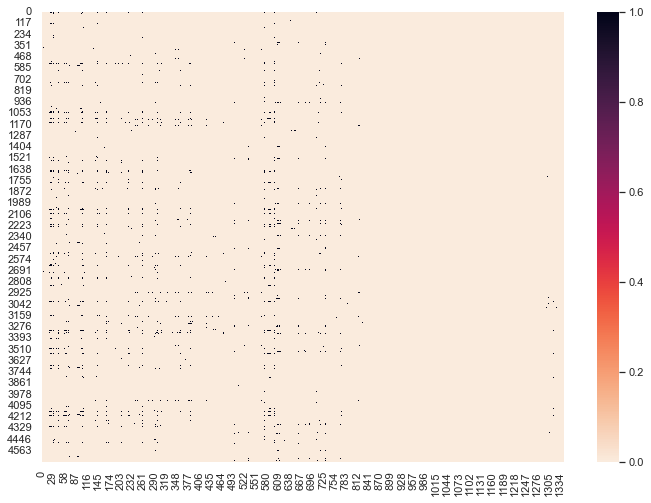

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(img_sim_bin12, cmap= sns.cm.rocket_r)

In [357]:
G_12_11 = nx.compose(G12, G11)

In [358]:
G_all = nx.compose(G_12_11, G22)

In [359]:
nx.write_gexf(G_all, "test2.gexf"), 

(None,)

# Older stuff

In [323]:
modality = 'image'
coll1 = 'smg'
coll2 = 'nms'

filter_smg = {
    "$and": [
        {
            "input_modality": {
                "$eq": modality
            }
        },
        {
            "collection": {
                "$eq" : coll1
            }
        }
    ]
}


smg_data = collection_db.get(
                where=filter_smg,
                include=['embeddings','metadatas']

                    )

filter_nms = {
    "$and": [
        {
            "input_modality": {
                "$eq": modality
            }
        },
        {
            "collection": {
                "$eq" : coll2
            }
        }
    ]
}

nms_data = collection_db.get(
                where=filter_nms,
                include=['embeddings','metadatas']
            )

In [324]:
smg_ids = smg_data['ids']
nms_ids = nms_data['ids']

smg_rids = [record['record_id'] for record in smg_data['metadatas']]
nms_rids = [record['record_id'] for record in nms_data['metadatas']]

smg_emb = np.matrix(smg_data['embeddings'])
nms_emb = np.matrix(nms_data['embeddings'])
image_similarities = 1 - sp.distance.cdist(smg_emb,nms_emb, 'cosine')

In [221]:
#imgs_sim_nms_nms = image_similarities

[Text(0, 0, 'SMG-NMS'), Text(1, 0, 'NMS-NMS'), Text(2, 0, 'SMG-SMG')]

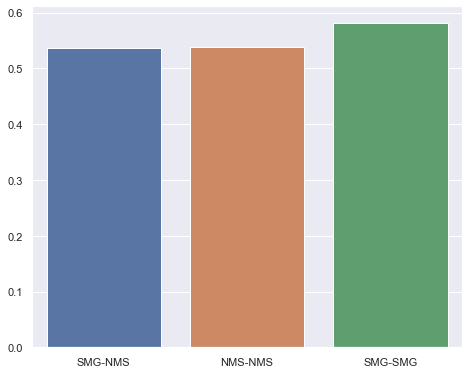

In [228]:
# ax = sns.barplot([imgs_sim_smg_nms.reshape(-1),
#              imgs_sim_nms_nms.reshape(-1),
#              imgs_sim_smg_smg.reshape(-1)],
#             errorbar=('ci', 95))
# ax.set_xticklabels(['SMG-NMS','NMS-NMS','SMG-SMG'])

[Text(0, 0, 'SMG-NMS'), Text(1, 0, 'NMS-NMS'), Text(2, 0, 'SMG-SMG')]

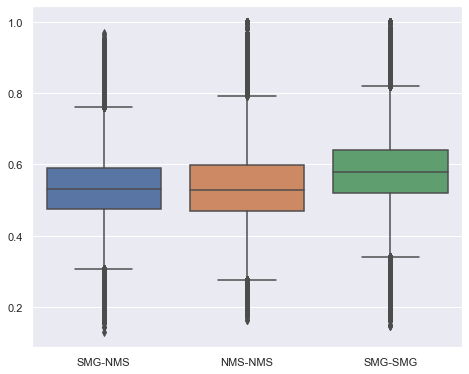

In [230]:
# ax = sns.boxplot([imgs_sim_smg_nms.reshape(-1),
#              imgs_sim_nms_nms.reshape(-1),
#              imgs_sim_smg_smg.reshape(-1)])
# ax.set_xticklabels(['SMG-NMS','NMS-NMS','SMG-SMG'])

<Axes: ylabel='Density'>

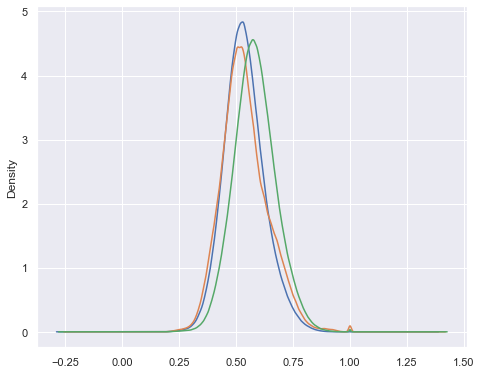

In [222]:
# pd.Series(imgs_sim_smg_nms.reshape(-1)).plot(kind='density')
# pd.Series(imgs_sim_nms_nms.reshape(-1)).plot(kind='density')
# pd.Series(imgs_sim_smg_smg.reshape(-1)).plot(kind='density')

In [207]:
#pd.Series(image_similarities.reshape(-1)).plot(kind='density')

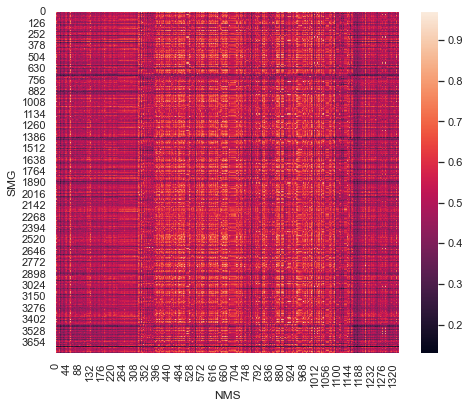

In [325]:
ax = sns.heatmap(image_similarities)
ax.set(xlabel='NMS', ylabel='SMG')
plt.show()

In [326]:
threshold = np.percentile(image_similarities.reshape(-1), 99.5) ; threshold

0.7947628429641663

<Axes: >

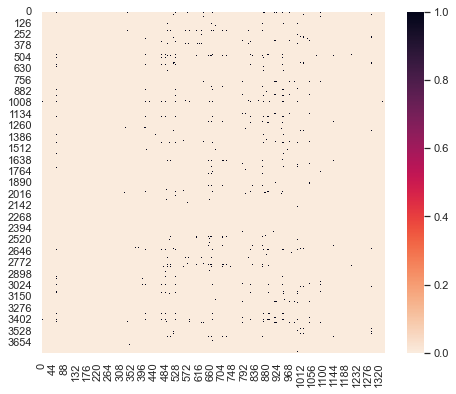

In [327]:
image_similarities[image_similarities >= threshold] = 1
image_similarities[image_similarities < threshold] = 0
sns.heatmap(image_similarities, cmap= sns.cm.rocket_r)

In [328]:
image_similarities.sum(axis=1).sum()

25313.0

In [330]:
(image_similarities.sum(axis=1).sum()/(image_similarities.shape[0]*image_similarities.shape[1]))*100

0.5000019752774277

In [331]:
connections = [(i,j) for i,j in zip(*np.where(image_similarities > 0))]

In [332]:
text_connections_with_rid = [(smg_rids[i],nms_rids[j]) for i,j in connections]

In [333]:
connections_with_rid[:10]

[('co33290', 'T.1966.3'),
 ('co33290', 'T.1915.11'),
 ('co8405136', 'T.1937.99'),
 ('co8405136', 'T.1938.140'),
 ('co8405136', 'T.1954.X.6'),
 ('co8405136', 'T.1961.68'),
 ('co8405136', 'T.1963.47'),
 ('co8405136', 'T.1965.42'),
 ('co8405136', 'T.1967.51'),
 ('co8405136', 'T.1967.52')]

In [334]:
len(connections_with_rid),len(set(connections_with_rid))

(50626, 50626)